# Keystroke Dynamics

### Importing libraries

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

## Data Loading and Preprocessing

### Loading data

In [151]:
df = pd.read_csv('data/StrongPasswordData.csv')
df.sum()

subject            s002s002s002s002s002s002s002s002s002s002s002s0...
sessionIndex                                                   91800
rep                                                           520200
H.period                                                   1904.9262
DD.period.t                                                5388.6217
UD.period.t                                                3483.6955
H.t                                                         1748.833
DD.t.i                                                     3449.3299
UD.t.i                                                     1700.4969
H.i                                                        1663.9357
DD.i.e                                                     3251.1835
UD.i.e                                                     1587.2478
H.e                                                        1818.4228
DD.e.five                                                  7699.6484
UD.e.five                         

In [152]:
df.head()

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,s002,1,1,0.1491,0.3979,0.2488,0.1069,0.1674,0.0605,0.1169,...,0.1349,0.1484,0.0135,0.0932,0.3515,0.2583,0.1338,0.3509,0.2171,0.0742
1,s002,1,2,0.1111,0.3451,0.2340,0.0694,0.1283,0.0589,0.0908,...,0.1412,0.2558,0.1146,0.1146,0.2642,0.1496,0.0839,0.2756,0.1917,0.0747
2,s002,1,3,0.1328,0.2072,0.0744,0.0731,0.1291,0.0560,0.0821,...,0.1621,0.2332,0.0711,0.1172,0.2705,0.1533,0.1085,0.2847,0.1762,0.0945
3,s002,1,4,0.1291,0.2515,0.1224,0.1059,0.2495,0.1436,0.1040,...,0.1457,0.1629,0.0172,0.0866,0.2341,0.1475,0.0845,0.3232,0.2387,0.0813
4,s002,1,5,0.1249,0.2317,0.1068,0.0895,0.1676,0.0781,0.0903,...,0.1312,0.1582,0.0270,0.0884,0.2517,0.1633,0.0903,0.2517,0.1614,0.0818


Anomaly detection per user (not general): it will allow us to detect if a user has a different typing pattern than usual. Keystroke dynamics are useful for this purpose because they are unique to each user.
However, we don't need the sessionIndex and rep columns, so we can drop them. They only indicate the number of times a user has logged in and typed their password within a session, respectively.

In [153]:
drop_cols = ['sessionIndex', 'rep']
df = df.drop(drop_cols, axis=1)
df.head()

,subject,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,DD.i.e,UD.i.e,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,s002,0.1491,0.3979,0.2488,0.1069,0.1674,0.0605,0.1169,0.2212,0.1043,...,0.1349,0.1484,0.0135,0.0932,0.3515,0.2583,0.1338,0.3509,0.2171,0.0742
1,s002,0.1111,0.3451,0.2340,0.0694,0.1283,0.0589,0.0908,0.1357,0.0449,...,0.1412,0.2558,0.1146,0.1146,0.2642,0.1496,0.0839,0.2756,0.1917,0.0747
2,s002,0.1328,0.2072,0.0744,0.0731,0.1291,0.0560,0.0821,0.1542,0.0721,...,0.1621,0.2332,0.0711,0.1172,0.2705,0.1533,0.1085,0.2847,0.1762,0.0945
3,s002,0.1291,0.2515,0.1224,0.1059,0.2495,0.1436,0.1040,0.2038,0.0998,...,0.1457,0.1629,0.0172,0.0866,0.2341,0.1475,0.0845,0.3232,0.2387,0.0813
4,s002,0.1249,0.2317,0.1068,0.0895,0.1676,0.0781,0.0903,0.1589,0.0686,...,0.1312,0.1582,0.0270,0.0884,0.2517,0.1633,0.0903,0.2517,0.1614,0.0818


Correlation matrix

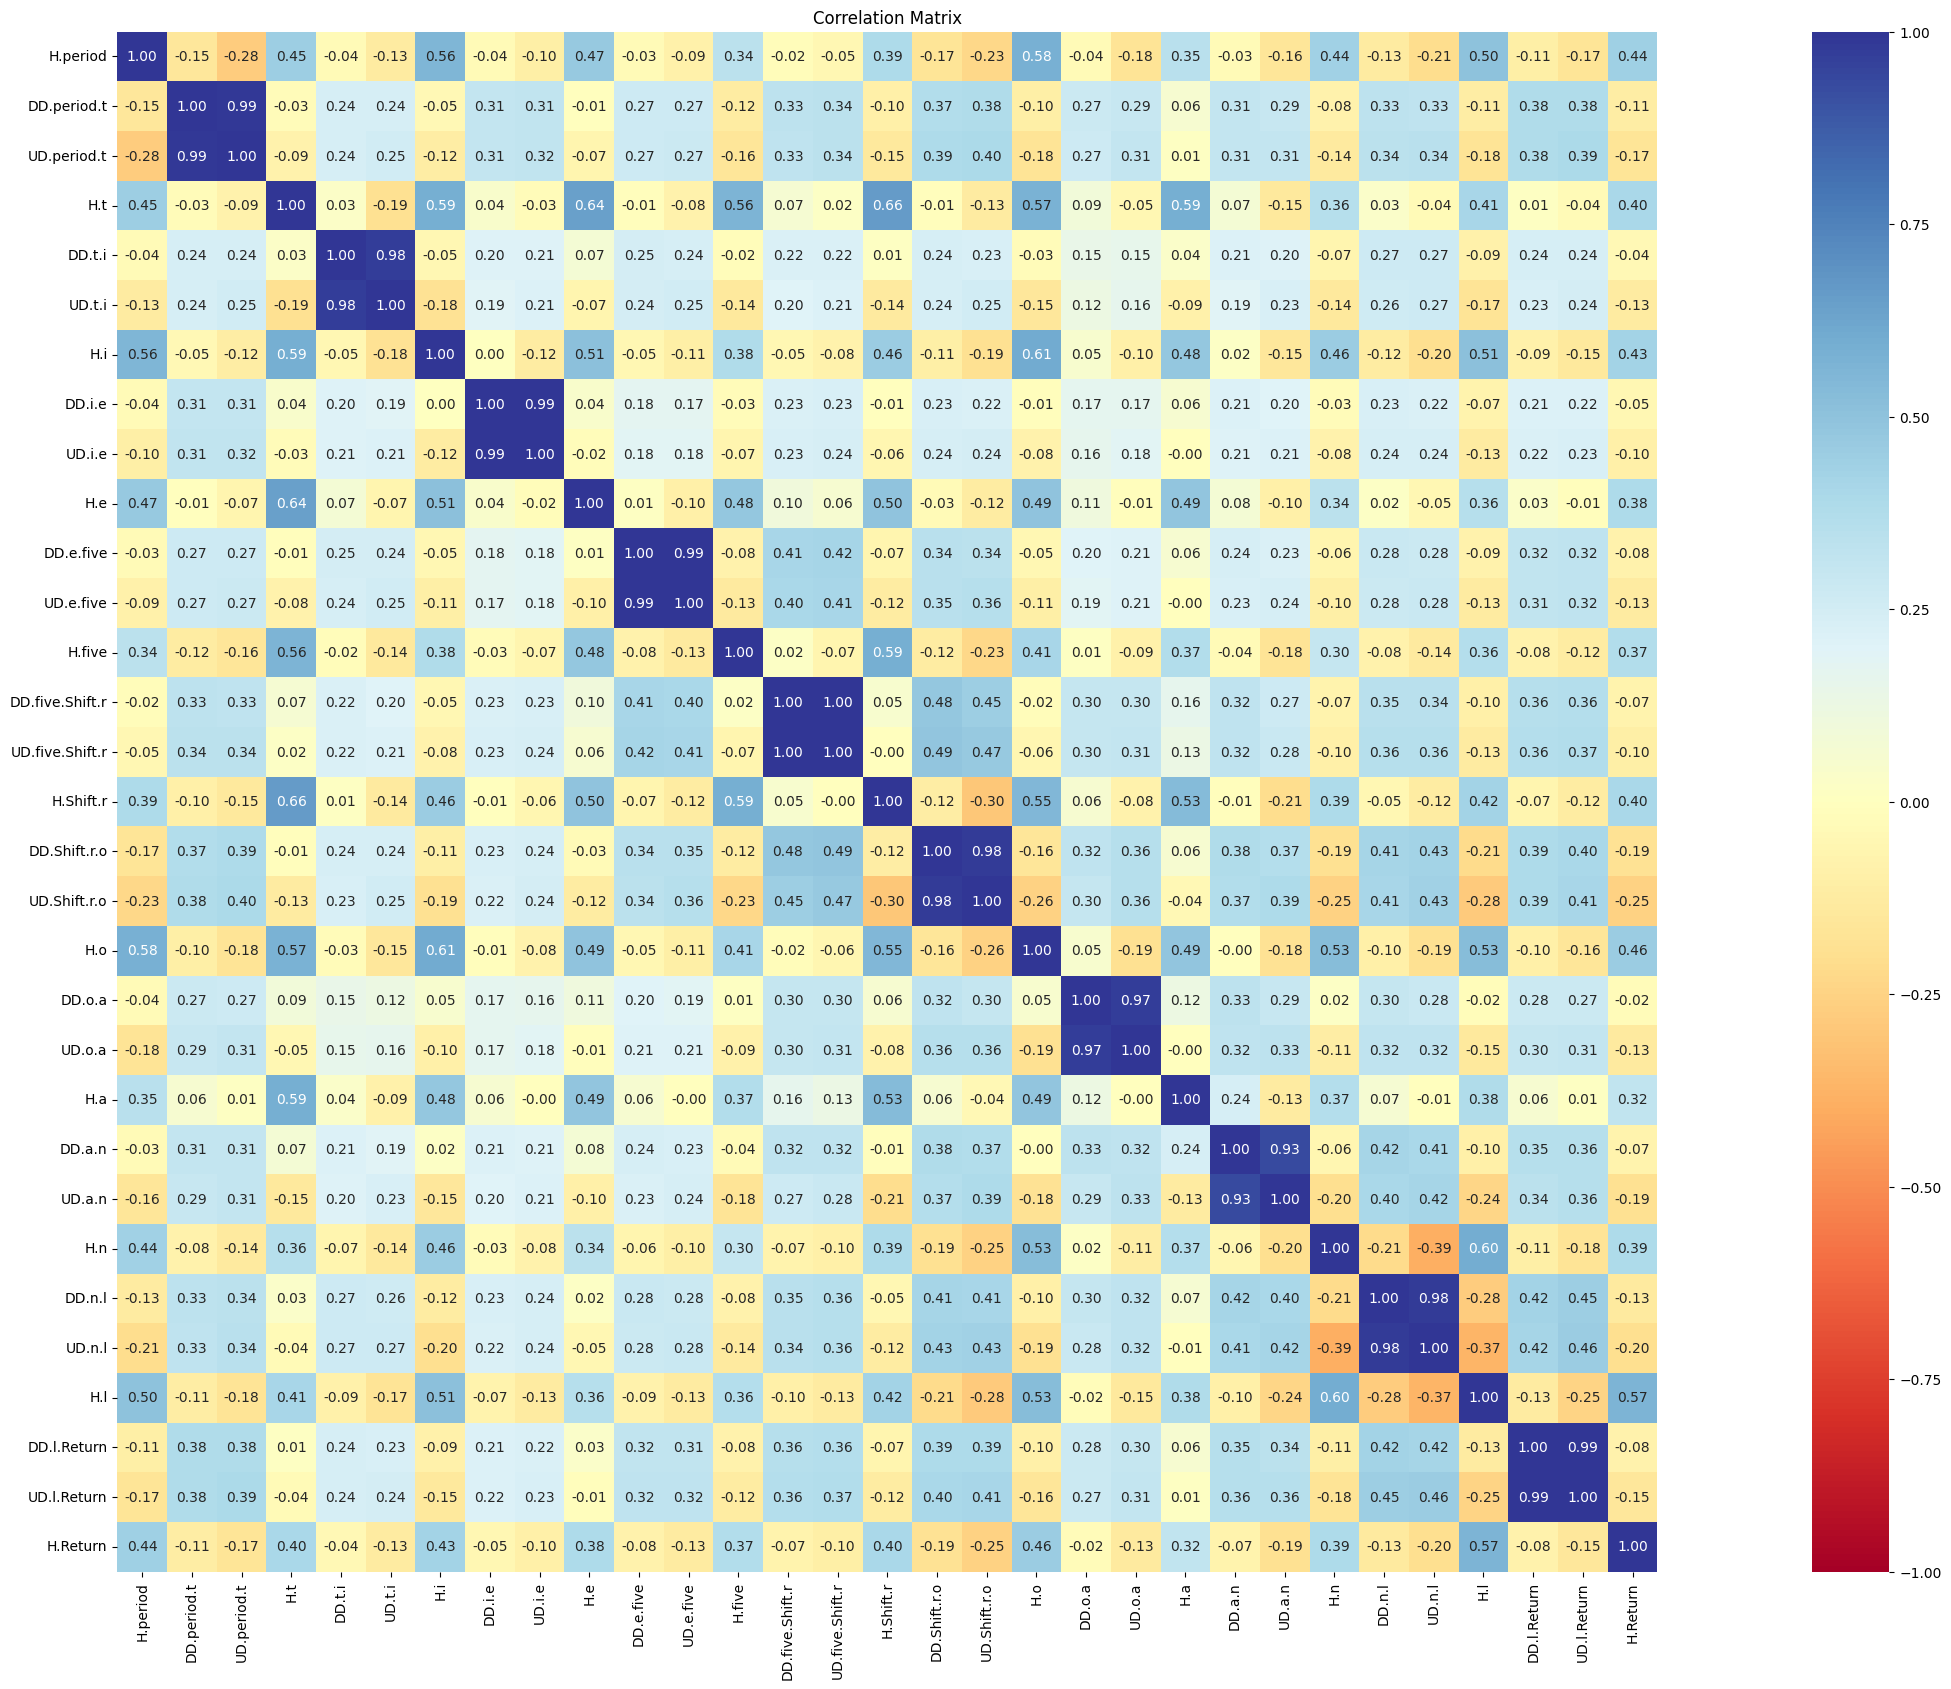

In [191]:
# Compute the correlation matrix
df_without_subject = df.drop('subject', axis=1)
corr_mat = df_without_subject.corr()

fig, ax = plt.subplots(figsize=(40, 20))
sns.heatmap(corr_mat, cmap='RdYlBu', annot=True, fmt='.2f', vmin=-1, vmax=1, square=True, ax=ax)
ax.set_title('Correlation Matrix')
plt.show()

This correlation matrix shows that the different types of keystrokes timing are highly correlated with each other. We also notice a high corelation between the different tested keys for a same type of keystroke timing. Thus, every column of this dataset is important for the classification task.

### Feature engineering

As the subject column is categorical , we need to encode it. We can use one-hot encoding for this purpose.
We choose one-hot encoding because we don't want to introduce any kind of ordinality in the data. Subjects are just labels that identify a user but are only nominal. They don't share relationship between them.

In [154]:
enc = preprocessing.OneHotEncoder()
enc.fit(df[['subject']])
onehotlabels = enc.transform(df[['subject']]).toarray()
onehotlabels.shape

(20400, 51)

We have 51 subjects, so we have 51 columns. Now, we are replacing the subject column with the one-hot encoded columns and dropping the original subject column thanks to the ColumnTransformer class from scikit-learn, we want to keep the rest of the columns as they are already numerical features.

In [155]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
unique_cols = df['subject'].nunique()

data = np.array(ct.fit_transform(df))

In [156]:
data[:5]

array([[1.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.1491, 0.3979, 0.2488, 0.1069, 0.1674,
        0.0605, 0.1169, 0.2212, 0.1043, 0.1417, 1.1885, 1.0468, 0.1146,
        1.6055, 1.4909, 0.1067, 0.759 , 0.6523, 0.1016, 0.2136, 0.112 ,
        0.1349, 0.1484, 0.0135, 0.0932, 0.3515, 0.2583, 0.1338, 0.3509,
        0.2171, 0.0742],
       [1.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    ,

In [157]:
X = data[:, unique_cols:]
y = data[:, :unique_cols]
print(y.shape)

(20400, 51)


## Data splitting

As a usual practice, we will split the dataset into 80% for training and 20% for testing. We want to stratify the split by subject, so we can have the same proportion of subjects in both sets.

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df['subject'], test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (16320, 31)
X_test shape: (4080, 31)
y_train shape: (16320, 51)
y_test shape: (4080, 51)


In [159]:
X_train[:5]

array([[ 0.0515,  0.1755,  0.124 ,  0.032 ,  0.0471,  0.0151,  0.0254,
         0.3914,  0.366 ,  0.0665,  0.5834,  0.5169,  0.0404,  0.3648,
         0.3244,  0.0541,  0.217 ,  0.1629,  0.0547,  0.1279,  0.0732,
         0.0591,  0.0602,  0.0011,  0.0462,  0.1528,  0.1066,  0.0599,
         0.1704,  0.1105,  0.0547],
       [ 0.1309,  0.4092,  0.2783,  0.0945,  0.1122,  0.0177,  0.1349,
         0.1338, -0.0011,  0.0843,  0.6247,  0.5404,  0.071 ,  0.3906,
         0.3196,  0.1307,  0.2212,  0.0905,  0.0953,  0.116 ,  0.0207,
         0.1241,  0.1598,  0.0357,  0.0892,  0.1528,  0.0636,  0.095 ,
         0.2073,  0.1123,  0.0961],
       [ 0.0679,  0.1718,  0.1039,  0.0856,  0.0787, -0.0069,  0.0914,
         0.0167, -0.0747,  0.0813,  0.1869,  0.1056,  0.076 ,  0.2118,
         0.1358,  0.0837,  0.1231,  0.0394,  0.076 ,  0.1152,  0.0392,
         0.1038,  0.0117, -0.0921,  0.0781,  0.0932,  0.0151,  0.0805,
         0.1804,  0.0999,  0.0478],
       [ 0.0963,  0.1825,  0.0862,  0.06

## Single models

### Random Forest Classifier

In [160]:
from sklearn.ensemble import RandomForestClassifier

In [161]:
rf = RandomForestClassifier(random_state=42, verbose=2)
rf.fit(X_train, y_train)
rf.predict(X_test)

print(f"Training set score: {rf.score(X_train, y_train)}")
print(f"Test set score: {rf.score(X_test, y_test)}")

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   19.9s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    2.2s


Training set score: 0.9998774509803922


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.5s


Test set score: 0.7


### K-Nearest Neighbors Classifier

In [162]:
from sklearn.neighbors import KNeighborsClassifier

In [163]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn.predict(X_test)

print(f"Training set score: {knn.score(X_train, y_train)}")
print(f"Test set score: {knn.score(X_test, y_test)}")

Training set score: 0.7469362745098039
Test set score: 0.6877450980392157


### Multi-Layer Perceptron Classifier

In [164]:
from sklearn.neural_network import MLPClassifier

In [165]:
mlp = MLPClassifier(random_state=42, max_iter=1000, verbose=1)
mlp.fit(X_train, y_train)
mlp.predict(X_test)

print(f"Training set score: {mlp.score(X_train, y_train)}")
print(f"Test set score: {mlp.score(X_test, y_test)}")

Iteration 1, loss = 18.09129648
Iteration 2, loss = 5.49977526
Iteration 3, loss = 5.25242135
Iteration 4, loss = 4.98265950
Iteration 5, loss = 4.74451788
Iteration 6, loss = 4.60797216
Iteration 7, loss = 4.51338817
Iteration 8, loss = 4.43261354
Iteration 9, loss = 4.35926092
Iteration 10, loss = 4.28747054
Iteration 11, loss = 4.21524951
Iteration 12, loss = 4.13947738
Iteration 13, loss = 4.05840319
Iteration 14, loss = 3.97512589
Iteration 15, loss = 3.88896014
Iteration 16, loss = 3.80307087
Iteration 17, loss = 3.72022670
Iteration 18, loss = 3.63663208
Iteration 19, loss = 3.55586542
Iteration 20, loss = 3.47737786
Iteration 21, loss = 3.39946898
Iteration 22, loss = 3.32274132
Iteration 23, loss = 3.25112446
Iteration 24, loss = 3.18439845
Iteration 25, loss = 3.12095487
Iteration 26, loss = 3.06324315
Iteration 27, loss = 3.00730252
Iteration 28, loss = 2.95602450
Iteration 29, loss = 2.90850056
Iteration 30, loss = 2.85967879
Iteration 31, loss = 2.81342610
Iteration 32, lo

C:\Users\Charles K\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


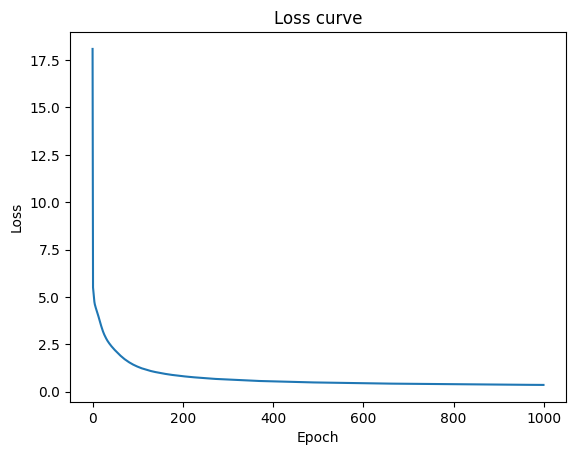

In [166]:
plt.figure()
plt.plot(mlp.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.show()

From the results above, we can say that the models that performed better were the Random Forest Classifier and the Multi-Layer Perceptron. Those models are capable of learning complex patterns in the data, so they are able to learn the keystroke dynamics of each user.
We can even test a deep neural network to see if it performs better than the MLP.

### Deep Neural Network

In [167]:
from tensorflow import keras
from tensorflow.keras import layers

In [168]:
# Define the architecture of the model
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', kernel_initializer='he_normal', input_shape=[X_train.shape[1]]),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(y_train.shape[1], activation='softmax')
    ])

    optimizer = keras.optimizers.Adam(0.001)
    loss = keras.losses.CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [169]:
# Build the model
model = build_model()

# Model summary
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 64)                2048      
                                                                 
 dense_37 (Dense)            (None, 64)                4160      
                                                                 
 dense_38 (Dense)            (None, 51)                3315      
                                                                 
Total params: 9523 (37.20 KB)
Trainable params: 9523 (37.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [170]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
510/510 [==============================] - 2s 3ms/step - loss: 3.3155 - accuracy: 0.1966 - val_loss: 2.6693 - val_accuracy: 0.3706
Epoch 2/50
510/510 [==============================] - 1s 2ms/step - loss: 2.2956 - accuracy: 0.4825 - val_loss: 2.0087 - val_accuracy: 0.5745
Epoch 3/50
510/510 [==============================] - 1s 2ms/step - loss: 1.7651 - accuracy: 0.6110 - val_loss: 1.6026 - val_accuracy: 0.6392
Epoch 4/50
510/510 [==============================] - 1s 2ms/step - loss: 1.4303 - accuracy: 0.6769 - val_loss: 1.3258 - val_accuracy: 0.7100
Epoch 5/50
510/510 [==============================] - 1s 2ms/step - loss: 1.2122 - accuracy: 0.7221 - val_loss: 1.1577 - val_accuracy: 0.7395
Epoch 6/50
510/510 [==============================] - 1s 2ms/step - loss: 1.0571 - accuracy: 0.7466 - val_loss: 1.0431 - val_accuracy: 0.7598
Epoch 7/50
510/510 [==============================] - 1s 2ms/step - loss: 0.9421 - accuracy: 0.7740 - val_loss: 0.9485 - val_accuracy: 0.7792
Epoch 

In [171]:
# Show history in dataframe
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = history.epoch
hist_df.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
45,0.252616,0.925674,0.392024,0.899755,45
46,0.245581,0.927267,0.417393,0.893382,46
47,0.244050,0.926225,0.390569,0.901961,47
48,0.240334,0.929289,0.377705,0.907108,48
49,0.235441,0.929534,0.387888,0.900000,49


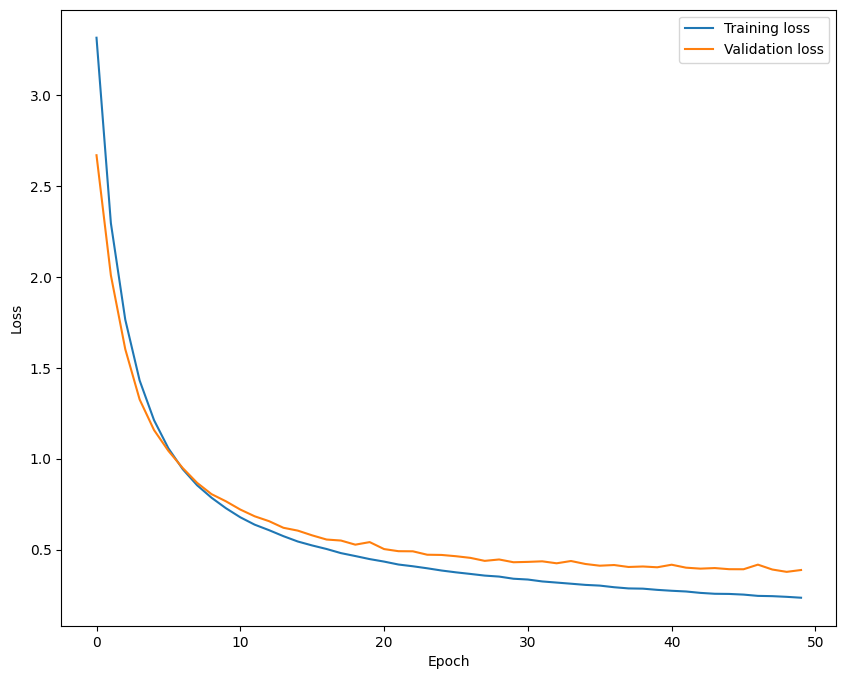

In [172]:
# Plot the loss curves
plt.figure(figsize=(10, 8))
plt.plot(hist_df['epoch'], hist_df['loss'], label='Training loss')
plt.plot(hist_df['epoch'], hist_df['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

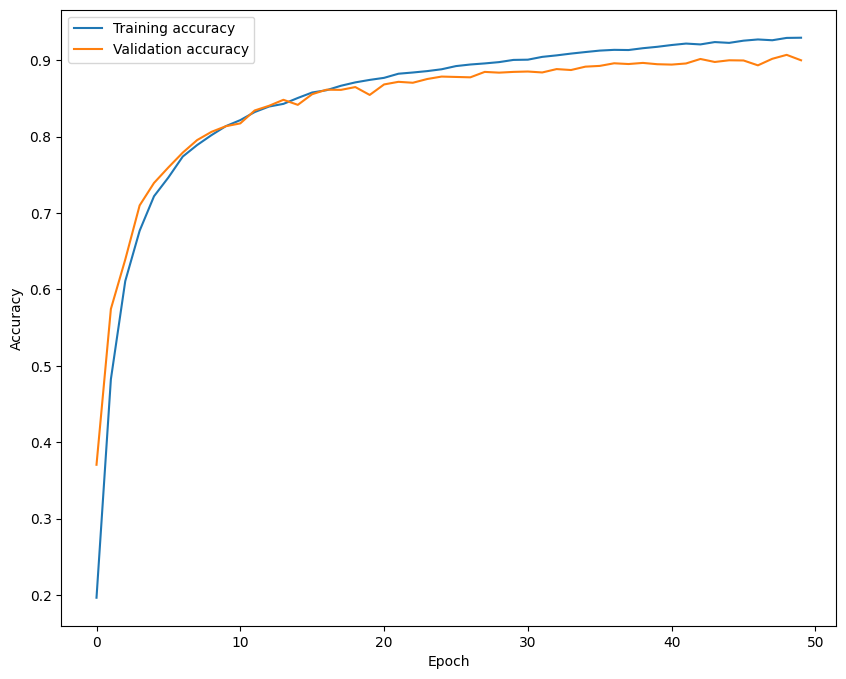

In [173]:
# Plot the accuracy curves
plt.figure(figsize=(10, 8))
plt.plot(hist_df['epoch'], hist_df['accuracy'], label='Training accuracy')
plt.plot(hist_df['epoch'], hist_df['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Visualize keystroke dynamics

We can visualize the keystroke dynamics of each user by plotting the mean of each feature for each user.

In [174]:
# Get the list of columns name for each types of keystroke timing (h, ud, dd)
h_cols = ['subject']
ud_cols = ['subject']
dd_cols = ['subject']

for column in df.columns:
    if 'H' in column:
        h_cols.append(str(column))
    if 'UD' in column:
        ud_cols.append(str(column))
    if 'DD' in column:
        dd_cols.append(str(column))

print(f"h columns: {h_cols}")
print(f"ud columns: {ud_cols}")
print(f"dd columns: {dd_cols}")

h columns: ['subject', 'H.period', 'H.t', 'H.i', 'H.e', 'H.five', 'H.Shift.r', 'H.o', 'H.a', 'H.n', 'H.l', 'H.Return']
ud columns: ['subject', 'UD.period.t', 'UD.t.i', 'UD.i.e', 'UD.e.five', 'UD.five.Shift.r', 'UD.Shift.r.o', 'UD.o.a', 'UD.a.n', 'UD.n.l', 'UD.l.Return']
dd columns: ['subject', 'DD.period.t', 'DD.t.i', 'DD.i.e', 'DD.e.five', 'DD.five.Shift.r', 'DD.Shift.r.o', 'DD.o.a', 'DD.a.n', 'DD.n.l', 'DD.l.Return']


H plot

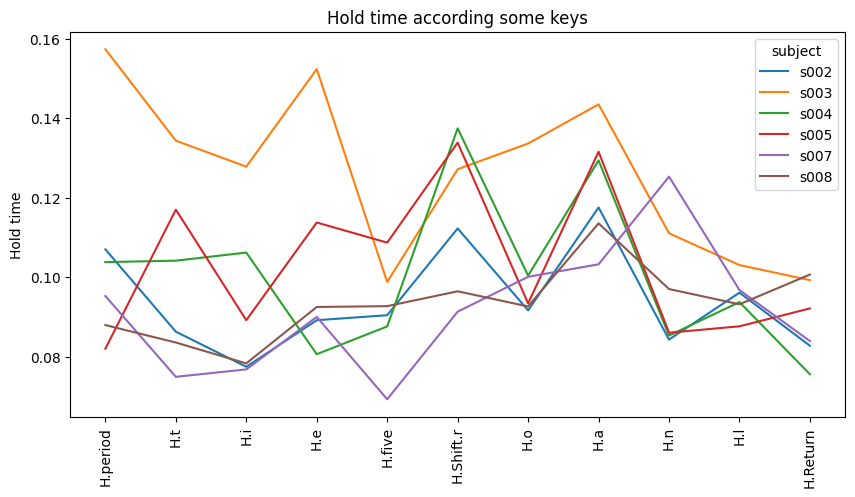

In [182]:
key_hold_time = df[h_cols]

key_hold_time = key_hold_time.where(
    (key_hold_time['subject'] == 's002') | (key_hold_time['subject'] == 's003') | (
            key_hold_time['subject'] == 's004') | (key_hold_time['subject'] == 's005') | (
            key_hold_time['subject'] == 's007') | (key_hold_time['subject'] == 's008'))

key_hold_time = key_hold_time.groupby('subject').agg('mean')

fig, ax = plt.subplots(figsize=(10, 5))
key_hold_time.T.plot(ax=ax)
ax.set_xticks(np.arange(len(key_hold_time.columns)))
ax.set_xticklabels(key_hold_time.columns, rotation=90)
plt.ylabel('Hold time')
plt.title("Hold time according some keys")
plt.show()

UD plot

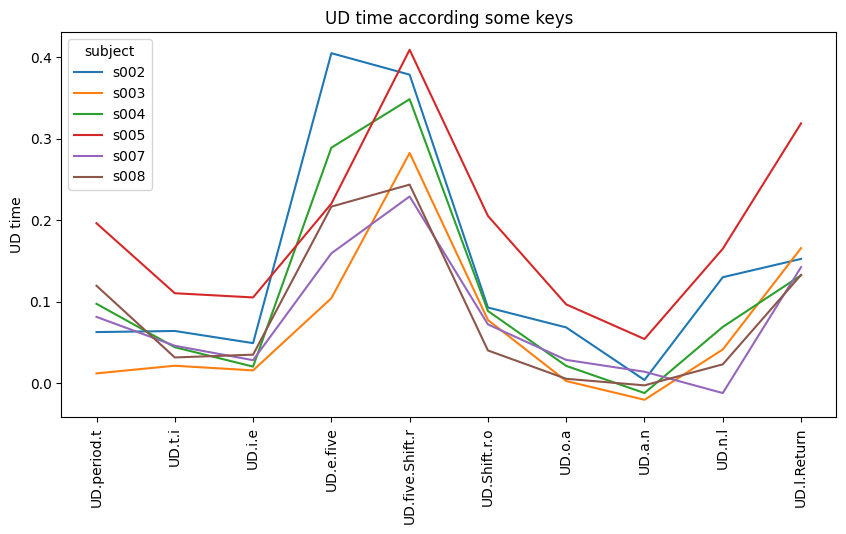

In [183]:
key_UD_latency = df[ud_cols]

key_UD_latency = key_UD_latency.where((key_UD_latency['subject'] == 's002') | (key_UD_latency['subject'] == 's003') | (
        key_UD_latency['subject'] == 's004') | (key_UD_latency['subject'] == 's005') | (
                                              key_UD_latency['subject'] == 's007') | (
                                              key_UD_latency['subject'] == 's008'))

key_UD_latency = key_UD_latency.groupby('subject').agg('mean')

fig, ax = plt.subplots(figsize=(10, 5))
key_UD_latency.T.plot(ax=ax)
ax.set_xticks(np.arange(len(key_UD_latency.columns)))
ax.set_xticklabels(key_UD_latency.columns, rotation=90)
plt.ylabel('UD time')
plt.title("UD time according some keys")
plt.show()

DD plot

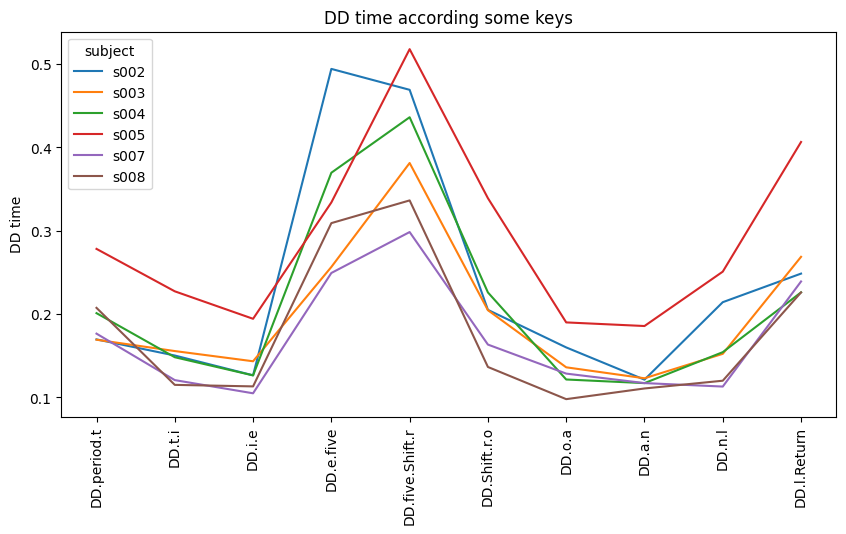

In [184]:
key_DD_latency = df[dd_cols]

key_DD_latency = key_DD_latency.where((key_DD_latency['subject'] == 's002') | (key_DD_latency['subject'] == 's003') | (
        key_DD_latency['subject'] == 's004') | (key_DD_latency['subject'] == 's005') | (
                                              key_DD_latency['subject'] == 's007') | (
                                              key_DD_latency['subject'] == 's008'))

key_DD_latency = key_DD_latency.groupby('subject').agg('mean')

fig, ax = plt.subplots(figsize=(10, 5))
key_DD_latency.T.plot(ax=ax)
ax.set_xticks(np.arange(len(key_DD_latency.columns)))
ax.set_xticklabels(key_DD_latency.columns, rotation=90)
plt.ylabel('DD time')
plt.title("DD time according some keys")
plt.show()